# *Outlines*

1: Loading 10-minute statistics of Preprocessed SCADA data

2: Plotting various SCADA parameters

3: Training a Neural Network with pre-defined architecture to predict Power

4: A simple BNN to predict Power and related Uncertainty

5: ---  

# **Introduction**

This workshop utilizes open source data from [Aventa AV-7 (6kW) IET-OST Research Wind Turbine SCADA](https://zenodo.org/records/17362783). The original dataset is 1Hz SCADA but is preprocessed in 10 minute SCADA statistics.

# *Loading Necessary Packages*

In [71]:
import warnings
warnings.filterwarnings('ignore')

# Packages for handling and processing load data
import numpy as np
import pandas as pd
import os

# Importing py_fatigue for load signals processing, fatigue damage and crack growth calculations
import py_fatigue as pf

#Packages for Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns  


# Loading Data

In [35]:
data_path = os.path.join(os.getcwd(),'AV-7-10min-Data.parquet')
data_ = pd.read_parquet(data_path)

In [39]:
data_

,rotor_speed-mean,rotor_speed-std,generator_speed-mean,generator_speed-std,generator_temperature-mean,generator_temperature-std,wind_speed-mean,wind_speed-std,power_output-mean,power_output-std,relative_wind_direction-mean,relative_wind_direction-std,blade_pitch_deg-mean,blade_pitch_deg-std
datetime,,,,,,,,,,,,,,
2025-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,6.727365,0.143893,1.600676,0.357373,0.000000,0.000000,-17.344595,16.689648,38.191855,0.0
2025-01-01 00:10:00,0.000000,0.000000,0.000000,0.000000,5.507227,0.169466,0.843529,0.453795,0.000000,0.000000,22.421849,42.560615,38.191855,0.0
2025-01-01 00:20:00,0.000000,0.000000,0.000000,0.000000,5.100671,0.008172,0.650168,0.367572,0.000000,0.000000,-11.436242,43.325591,38.191855,0.0
2025-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,5.100000,0.000000,0.857358,0.476135,0.000000,0.000000,-30.479933,16.536506,38.191855,0.0
2025-01-01 00:40:00,0.000000,0.000000,0.000000,0.000000,4.745059,0.371235,0.303350,0.380818,0.000000,0.000000,-19.075377,38.734200,38.191855,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-09 12:40:00,50.984975,4.233807,617.263773,45.711439,34.957930,0.887369,3.665609,0.400525,3.065159,0.825066,-9.375626,9.676237,14.034000,0.0
2025-05-09 12:50:00,42.298829,6.792252,520.538462,77.421086,35.555686,0.641574,3.044147,0.524340,1.725251,0.803330,-0.130435,17.377079,14.034000,0.0
2025-05-09 13:00:00,30.985643,3.338324,389.938230,39.031689,32.861603,0.481144,2.320701,0.409591,0.489750,0.231132,-3.681135,23.353618,14.034000,0.0


# Plotting Power Curve

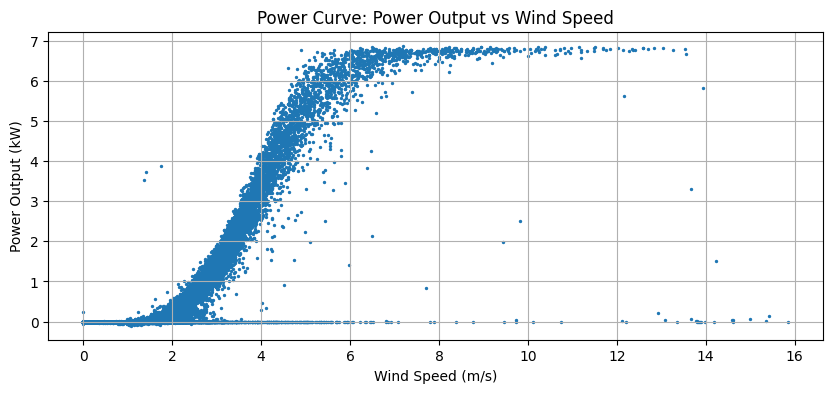

In [57]:
plt.figure(figsize=(10,4))
plt.scatter(data_['wind_speed-mean'], data_['power_output-mean'], s=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Power Curve: Power Output vs Wind Speed')
plt.grid()
plt.show()

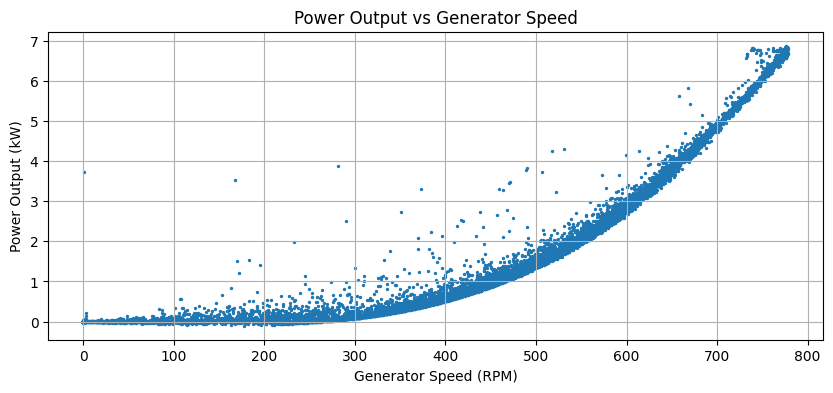

In [56]:
plt.figure(figsize=(10,4))
plt.scatter(data_['generator_speed-mean'], data_['power_output-mean'], s=2)
plt.xlabel('Generator Speed (RPM)')
plt.ylabel('Power Output (kW)')
plt.title('Power Output vs Generator Speed')
plt.grid()
plt.show()

In [78]:
data_['Operation_Status'] = np.where(data_['power_output-mean'] < 0.05, 'Parked', 'Operating')
data_['Operation_Status'].value_counts()/len(data_)*100

Operation_Status
Operating    51.995895
Parked       48.004105
Name: count, dtype: float64

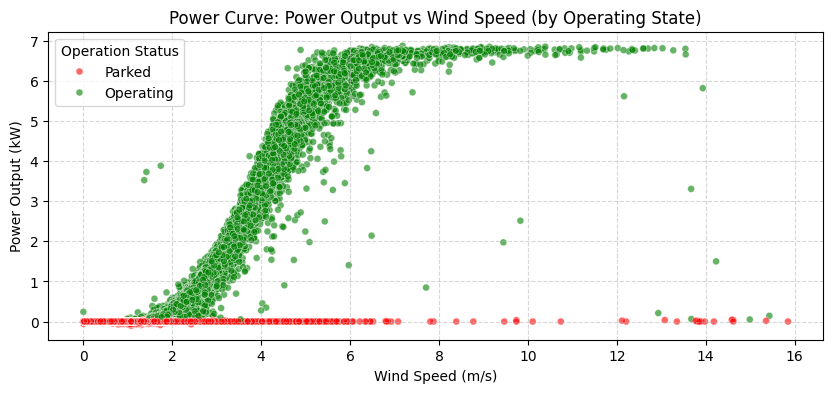

In [75]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=data_,
    x='wind_speed-mean',
    y='power_output-mean',
    hue='Operation_Status',
    palette={'Parked': 'red', 'Operating': 'green'},
    s=25,
    alpha=0.6
)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Power Curve: Power Output vs Wind Speed (by Operating State)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Operation Status')
plt.show()

# Artificial Neural Network to predict Power